# Extended Kalman Filter Localization

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot

Q = np.diag([
  0.1,  # variance of location on x-axis
  0.1,  # variance of location on y-axis
  np.deg2rad(1.0),  # variance of yaw angle
  1.0  # variance of velocity
]) ** 2  # predict state covariance

R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_animation = True

## Filter design

In this simulation, the robot has a state vector includes 4 states at time $t$.

$$\textbf{x}_t=[x_t, y_t, \phi_t, v_t]$$

x, y are a 2D x-y position, $\phi$ is orientation, and v is velocity.

In the code, "xEst" means the state vector. [code](https://github.com/AtsushiSakai/PythonRobotics/blob/916b4382de090de29f54538b356cef1c811aacce/Localization/extended_kalman_filter/extended_kalman_filter.py#L168)

And, $P_t$ is covariace matrix of the state,

$Q$ is covariance matrix of process noise, 

$R$ is covariance matrix of observation noise at time $t$ 


In [3]:
x_state = np.array([0, 0, np.deg2rad(0), 2]).reshape(4,-1)
x_state

array([[0.],
       [0.],
       [0.],
       [2.]])

The robot has a speed sensor and a gyro sensor.

So, the input vecor can be used as each time step

$$\textbf{u}_t=[v_t, \omega_t]$$

Also, the robot has a GNSS sensor, it means that the robot can observe x-y position at each time.

$$\textbf{z}_t=[x_t,y_t]$$

The input and observation vector includes sensor noise.

In [4]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

u = calc_input()
u

array([[1. ],
       [0.1]])

### Motion Model
The robot model is 

$$ \dot{x} = vcos(\phi)$$

$$ \dot{y} = vsin((\phi)$$

$$ \dot{\phi} = \omega$$

Given that   
$\textbf{x}_t = [x_t, y_t, \phi_t, v_t]$  

$\textbf{x}_{t+1}$  
$x_{t+1} = x_t + \dot{x}\Delta t$  
$y_{t+1} = y_t + \dot{y}\Delta t$  
$\phi_{t+1} = \phi_t + \dot{\phi}\Delta t$  
$v_{t+1} = 0 + v_{t+1}$


$\textbf{u}_t = [v_t, \dot{\phi}]$

So, the motion model is

$$\textbf{x}_{t+1} = F\textbf{x}_t+B\textbf{u}_t$$

where

$\begin{equation*}
F=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
cos(\phi)\Delta t & 0\\
sin(\phi)\Delta t & 0\\
0 & \Delta t\\
1 & 0\\
\end{bmatrix}
\end{equation*}$



In [5]:
def motion_model(x, u, dt):
  F = np.array([[1.0, 0,  0,  0],
          [0,  1.0, 0,  0],
          [0,  0,  1.0, 0],
          [0,  0,  0,  0]])
  B = np.array([[dt * math.cos(x[2, 0]), 0 ],
          [dt * math.sin(x[2, 0]), 0 ],
          [0.0,            dt ],
          [1.0,            0.0]])
  x = F@x + B@u
  return x

# x = 0 + v_u*cos(0)*dt = 0.1
# y = 0 + v_u*sin(0)*dt = 0
# yaw = v_yaw * dt = 0.01
# v = v_u = 1
motion_model(x_state, u, DT)

array([[0.1 ],
       [0.  ],
       [0.01],
       [1.  ]])

Its Jacobian matrix is

$\begin{equation*}
J_F=
\begin{bmatrix}
\frac{dx}{dx}& \frac{dx}{dy} & \frac{dx}{d\phi} &  \frac{dx}{dv}\\
\frac{dy}{dx}& \frac{dy}{dy} & \frac{dy}{d\phi} &  \frac{dy}{dv}\\
\frac{d\phi}{dx}& \frac{d\phi}{dy} & \frac{d\phi}{d\phi} &  \frac{d\phi}{dv}\\
\frac{dv}{dx}& \frac{dv}{dy} & \frac{dv}{d\phi} &  \frac{dv}{dv}\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
　=
\begin{bmatrix}
1& 0 & -v sin(\phi)dt &  cos(\phi)dt\\
0 & 1 & v cos(\phi)dt & sin(\phi) dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
\end{equation*}$

In [6]:
def jacob_f(x, u, DT):
  """
  Jacobian of Motion Model motion model
  """
  yaw = x[2, 0]
  v = u[0, 0]
  jF = np.array([
      [1.0, 0.0, -DT*v*math.sin(yaw), DT*math.cos(yaw)],
      [0.0, 1.0, DT*v*math.cos(yaw), DT*math.sin(yaw)],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]])

  return jF

### Observation Model

The robot can get x-y position infomation from GPS.

Given that   
$\textbf{x}_t = [x_t, y_t, \phi_t, v_t]$  
$\textbf{z}_t=[x_t,y_t]$

So GPS Observation model is

$$\textbf{z}_{t} = H\textbf{x}_t$$

where

$\begin{equation*}
H=
\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
\end{bmatrix}
\end{equation*}$

Its Jacobian matrix is

$\begin{equation*}
J_H=
\begin{bmatrix}
\frac{dx}{dx}& \frac{dx}{dy} & \frac{dx}{d\phi} &  \frac{dx}{dv}\\
\frac{dy}{dx}& \frac{dy}{dy} & \frac{dy}{d\phi} &  \frac{dy}{dv}\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
　=
\begin{bmatrix}
1& 0 & 0 & 0\\
0 & 1 & 0 & 0\\
\end{bmatrix}
\end{equation*}$



In [7]:
def observation_model(x):
  H = np.array([[1, 0, 0, 0],
          [0, 1, 0, 0]])
  z = H @ x
  return z

def jacob_h():
  # Jacobian of Observation Model
  jH = np.array([[1, 0, 0, 0],
           [0, 1, 0, 0]])
  return jH

### Extented Kalman Filter

Localization process using Extendted Kalman Filter:EKF is

=== Predict ===

$x_{Pred} = Fx_t+Bu_t$

$P_{Pred} = J_FP_t J_F^T + Q$

=== Update ===

$z_{Pred} = Hx_{Pred}$ 

$y = z - z_{Pred}$

$S = J_H P_{Pred}.J_H^T + R$

$K = P_{Pred}.J_H^T S^{-1}$

$x_{t+1} = x_{Pred} + Ky$

$P_{t+1} = ( I - K J_H) P_{Pred}$



In [8]:
def ekf_estimation(xEst, PEst, z, u, dt):
  # Predict
  xPred = motion_model(xEst, u, dt)
  jF = jacob_f(xEst, u, dt)
  PPred = jF @ PEst @ jF.T + Q

  # Update
  jH = jacob_h()
  zPred = observation_model(xPred)
  y = z - zPred
  S = jH @ PPred @ jH.T + R
  K = PPred @ jH.T @ np.linalg.inv(S)
  xEst = xPred + K @ y
  PEst = (np.eye(len(xEst)) - K @ jH) @ PPred
  return xEst, PEst

xEst = np.zeros((4, 1)) # State Vector [x y yaw v]
PEst = np.eye(4) # Covariace matrix of the state
z = observation_model(xEst)
dt = 0.1  # time tick [s]
u = calc_input()
ekf_estimation(xEst, PEst, z, u, dt)

(array([[0.04950495],
        [0.        ],
        [0.01      ],
        [0.9950495 ]]),
 array([[0.5049505 , 0.        , 0.        , 0.04950495],
        [0.        , 0.5049505 , 0.04950495, 0.        ],
        [0.        , 0.04950495, 0.99535412, 0.        ],
        [0.04950495, 0.        , 0.        , 1.9950495 ]]))

In [9]:
# Simulation parameter
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

def observation(xTrue, u, dt):
  xTrue = motion_model(xTrue, u, dt)
  
  # add noise to gps x-y
  z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)
 
  # add noise to input
  ud = u + INPUT_NOISE @ np.random.randn(2, 1)
  return xTrue, z, ud


xs_init = np.zeros((4,1))
u = calc_input()
xTrue, z, ud = observation(xs_init, u, dt=1)
xRaw = motion_model(xs_init, ud, dt=1)

print(xTrue)
print(xRaw)
print(z)
print(ud)

[[1. ]
 [0. ]
 [0.1]
 [1. ]]
[[2.31589188]
 [0.        ]
 [0.18290528]
 [2.31589188]]
[[1.46433487]
 [0.22398672]]
[[2.31589188]
 [0.18290528]]


In [10]:
def plot_covariance_ellipse(xEst, PEst):
  Pxy = PEst[0:2, 0:2]
  eigval, eigvec = np.linalg.eig(Pxy)

  if eigval[0] >= eigval[1]:
    bigind = 0
    smallind = 1
  else:
    bigind = 1
    smallind = 0

  t = np.arange(0, 2*math.pi + 0.1, 0.1)
  a = math.sqrt(eigval[bigind])
  b = math.sqrt(eigval[smallind])
  x = [a * math.cos(it) for it in t]
  y = [b * math.sin(it) for it in t]
  angle = math.atan2(eigvec[1,bigind], eigvec[0,bigind])
  rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
  fx = rot @ (np.array([x,y]))
  px = np.array(fx[0,:] + xEst[0,0]).flatten()
  py = np.array(fx[1,:] + xEst[1,0]).flatten()
  plt.plot(px, py, "--r")


This is a sensor fusion localization with Extended Kalman Filter(EKF).

The blue line is true trajectory, the black line is dead reckoning
trajectory,

the green point is positioning observation (ex. GPS), and the red line
is estimated trajectory with EKF.

The red ellipse is estimated covariance ellipse with EKF.

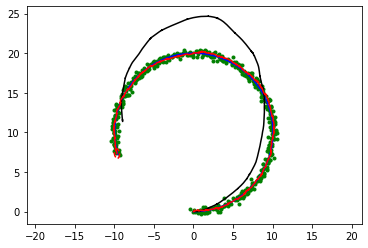

In [11]:
from IPython import display

time = 0.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

fig = plt.figure()
plt.axis("equal")
plt.grid(True)
while SIM_TIME >= time:
  time += DT
  u = calc_input()

  xTrue, z, ud = observation(xTrue, u, DT)
  xDR = motion_model(xDR, ud, dt=DT) # Only compute with ud
  xEst, PEst = ekf_estimation(xEst, PEst, z, ud, dt=DT)

  # store data history
  hxEst = np.hstack((hxEst, xEst))
  hxDR = np.hstack((hxDR, xDR))
  hxTrue = np.hstack((hxTrue, xTrue))
  hz = np.hstack((hz, z))

  if show_animation:
    plt.cla()
    # # for stopping simulation with the esc key.
    # plt.gcf().canvas.mpl_connect('key_release_event',
    #     lambda event: [exit(0) if event.key == 'escape' else None])
    plt.plot(hz[0,:], hz[1,:], ".g")
    plt.plot(hxTrue[0,:].flatten(),
         hxTrue[1,:].flatten(), "-b")
    plt.plot(hxDR[0,:].flatten(),
         hxDR[1,:].flatten(), "-k")
    plt.plot(hxEst[0,:].flatten(),
         hxEst[1,:].flatten(), "-r")
    plot_covariance_ellipse(xEst, PEst)

    display.display(fig)
    display.clear_output(wait=True)
